In [1]:
cd ..

/Users/deepakduggirala/Documents/autonomous-robotics/bev-generation


https://ai4ce.github.io/V2X-Sim/data.html

In [40]:
import os
from pathlib import Path
import itertools
from io import BytesIO
import time
import json
from collections import OrderedDict, namedtuple

import numpy as np
import scipy
import pandas as pd

import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.neighbors import KNeighborsClassifier

from nuscenes.nuscenes import NuScenes

import lmdb

from tqdm import tqdm

import utils
from utils import bytes_to_array
import nusc_utils

from bev_gt import generate_gt_bev_map, load_map_data
from bev2 import BEV, generate_bev_seg_map

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
dataroot = Path('/Users/deepakduggirala/Documents/autonomous-robotics/V2X-Sim-2.0-mini/').resolve()
nuscenes = NuScenes(version='v2.0-mini', dataroot=str(dataroot), verbose=False)

In [130]:
scene = nuscenes.scene[0]
sample = list(nusc_utils.sample_gen(nuscenes, scene))[0]

In [184]:
sorted(sample['data'].keys())

['BEV_TOP_id_0',
 'BEV_TOP_id_1',
 'BEV_TOP_id_2',
 'BEV_TOP_id_3',
 'BEV_TOP_id_4',
 'BEV_TOP_id_5',
 'CAM_BACK_LEFT_id_1',
 'CAM_BACK_LEFT_id_2',
 'CAM_BACK_LEFT_id_3',
 'CAM_BACK_LEFT_id_4',
 'CAM_BACK_LEFT_id_5',
 'CAM_BACK_RIGHT_id_1',
 'CAM_BACK_RIGHT_id_2',
 'CAM_BACK_RIGHT_id_3',
 'CAM_BACK_RIGHT_id_4',
 'CAM_BACK_RIGHT_id_5',
 'CAM_BACK_id_1',
 'CAM_BACK_id_2',
 'CAM_BACK_id_3',
 'CAM_BACK_id_4',
 'CAM_BACK_id_5',
 'CAM_FRONT_LEFT_id_1',
 'CAM_FRONT_LEFT_id_2',
 'CAM_FRONT_LEFT_id_3',
 'CAM_FRONT_LEFT_id_4',
 'CAM_FRONT_LEFT_id_5',
 'CAM_FRONT_RIGHT_id_1',
 'CAM_FRONT_RIGHT_id_2',
 'CAM_FRONT_RIGHT_id_3',
 'CAM_FRONT_RIGHT_id_4',
 'CAM_FRONT_RIGHT_id_5',
 'CAM_FRONT_id_1',
 'CAM_FRONT_id_2',
 'CAM_FRONT_id_3',
 'CAM_FRONT_id_4',
 'CAM_FRONT_id_5',
 'CAM_id_0_0',
 'CAM_id_0_1',
 'CAM_id_0_2',
 'CAM_id_0_3',
 'DEP_BACK_LEFT_id_1',
 'DEP_BACK_LEFT_id_2',
 'DEP_BACK_LEFT_id_3',
 'DEP_BACK_LEFT_id_4',
 'DEP_BACK_LEFT_id_5',
 'DEP_BACK_RIGHT_id_1',
 'DEP_BACK_RIGHT_id_2',
 'DEP_BACK

(256, 256) uint8


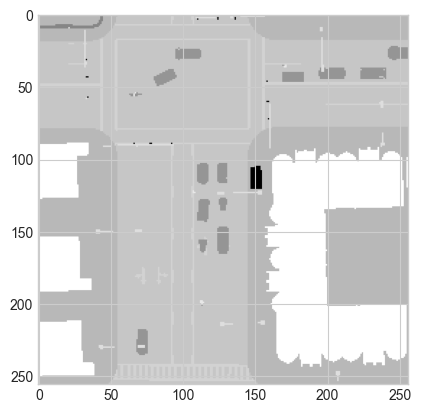

In [169]:
bev_data = nuscenes.get('sample_data', sample['data']['BEV_TOP_id_1'])
bev_top = np.load(str(dataroot / bev_data['filename']), 'r')['arr_0']
print(bev_top.shape, bev_top.dtype)
plt.imshow(bev_top)

In [140]:
class_to_rgb = {
    0: [255, 255, 255],  # Unlabeled
    1: [71, 141, 230],  # Vehicles
    2: [122, 217, 209],  # Sidewalk
    3: [145, 171, 100],  # Ground / Terrain
    4: [231, 136, 101],  # Road / Traffic light / Pole
    5: [142, 80, 204],  # Buildings
    6: [224, 8, 50],  # Pedestrian
    7: [106, 142, 34]  # Vegetation
    # 7: [102, 102, 156],  # Walls
    # 0: [55, 90, 80],  # Other
}

# Remap pixel values given by carla
classes_remap = {
    0: 0,  # Unlabeled (so that we don't forget this class)
    10: 1,  # Vehicles
    8: 2,  # Sidewalk
    14: 3,  # Ground (non-drivable)
    22: 3,  # Terrain (non-drivable)
    7: 4,  # Road
    6: 4,  # Road line
    18: 4,  # Traffic light
    5: 4,  # Pole
    1: 5,  # Building
    4: 6,  # Pedestrian
    9: 7,  # Vegetation
}

class_idx_to_name = {
    0: "Unlabeled",
    1: "Vehicles",
    2: "Sidewalk",
    3: "Ground & Terrain",
    4: "Road",
    5: "Buildings",
    6: "Pedestrian",
    7: "Vegetation",
}


(-0.5, 124.5, 124.5, -0.5)

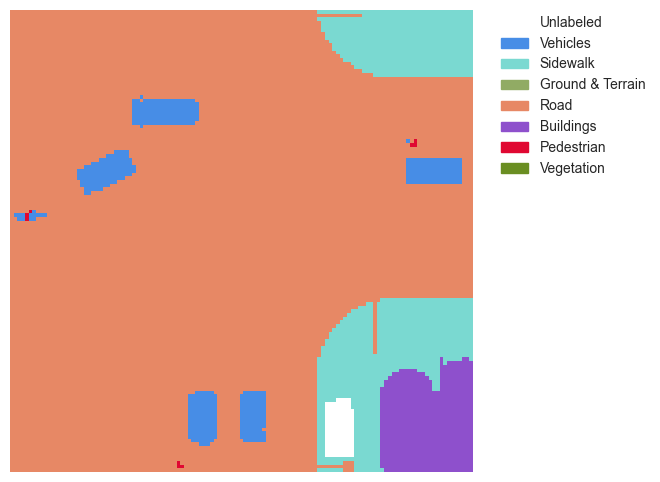

In [182]:
H,W = bev_top.shape
bev_rgb = np.zeros((H, W, 3), dtype=np.uint8)

for cls_i in np.unique(bev_top):
    ii, jj = np.where(bev_top == cls_i)
    cls_j = classes_remap.get(cls_i, 0)
    color = class_to_rgb[cls_j]
    bev_rgb[ii, jj, :] = color

fig, axs = plt.subplots(figsize=(15, 6))
axs.imshow(bev_rgb[:125,62:187]) #[:125,62:187]
legend_colors = [
    np.append(np.array(class_to_rgb[idx]) / 255, 1) for idx in range(len(class_to_rgb))
]
patches = [mpatches.Patch(color=legend_colors[i], label=label)
           for i, label in class_idx_to_name.items()]
axs.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs.axis('off')

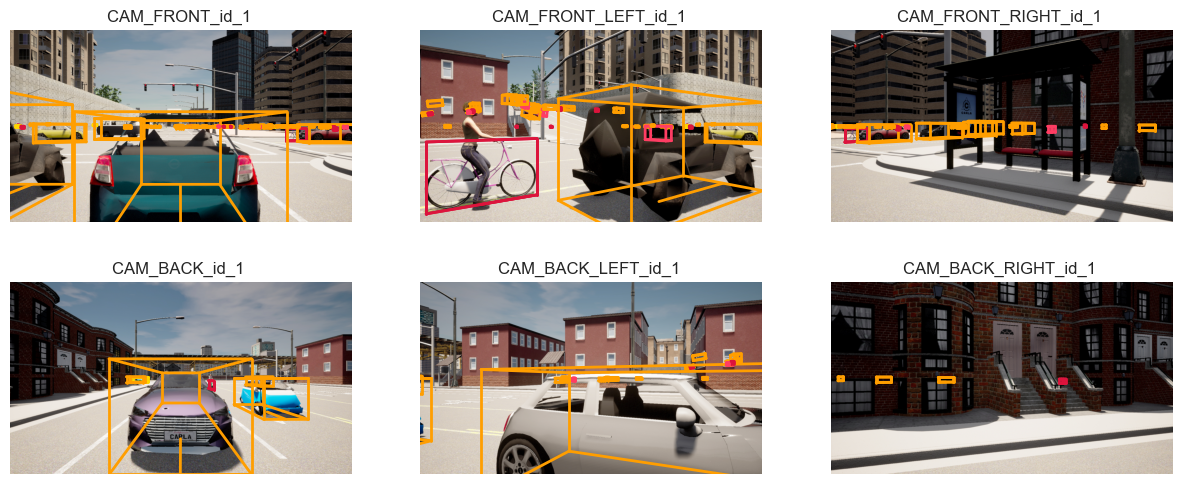

In [174]:
num_rows = 2
num_cols = 3

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6))
channels = ['CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT', 'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT']

vehicle_id = 1

for i in range(num_rows):
    for j in range(num_cols):
        channel = channels[i * num_cols + j]
        sample_data = nuscenes.get('sample_data', sample['data'][f'{channel}_id_{vehicle_id}'])
        nuscenes.render_sample_data(sample_data['token'], ax=axs[i, j], verbose=False)


In [165]:
cam_front_data = nuscenes.get('sample_data', sample['data']['CAM_FRONT_id_1'])
cam_bev_to_map_tfm = nusc_utils.get_sensor_transform(nuscenes, cam_front_data)
np.round(cam_bev_to_map_tfm,2)

array([[-1.0000e+00,  0.0000e+00, -3.0000e-02, -3.6300e+00],
       [ 3.0000e-02,  0.0000e+00, -1.0000e+00,  1.5595e+02],
       [ 0.0000e+00, -1.0000e+00,  0.0000e+00,  1.3800e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [166]:
bev_data = nuscenes.get('sample_data', sample['data']['BEV_TOP_id_1'])
bev_top_to_map_tfm = nusc_utils.get_sensor_transform(nuscenes, bev_data)
np.round(bev_top_to_map_tfm,2)

array([[-1.0000e+00,  3.0000e-02, -0.0000e+00, -3.6200e+00],
       [ 3.0000e-02,  1.0000e+00, -0.0000e+00,  1.5651e+02],
       [-0.0000e+00, -0.0000e+00, -1.0000e+00,  2.0000e+01],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [168]:
bev_top_to_cam_bev_tfm = np.linalg.inv(cam_bev_to_map_tfm) @ bev_top_to_map_tfm
np.round(bev_top_to_cam_bev_tfm,2)[[0, 1, 3]][:, [0, 2, 3]]

array([[  1.  ,  -0.  ,   0.  ],
       [  0.  ,   1.  , -18.62],
       [  0.  ,   0.  ,   1.  ]])

In [170]:
bev_data

{'token': '3n50wa2ub11899tn176pzd5dmt1kya5k',
 'sample_token': 'q68g8v6474j10l675mphs2r8w97575ca',
 'ego_pose_token': '3n50wa2ub11899tn176pzd5dmt1kya5k',
 'calibrated_sensor_token': '56fo5x1x69gbv44yg7hi5o1srepd15qe',
 'timestamp': 6,
 'fileformat': 'npz',
 'is_key_frame': True,
 'height': 256,
 'width': 256,
 'filename': 'sweeps/BEV_TOP_id_1/scene_5_000006.npz',
 'prev': '',
 'next': 'j1db06n2b26mqrkhjk34pi504340o146',
 'sensor_modality': 'camera',
 'channel': 'BEV_TOP_id_1'}

In [172]:
nuscenes.get('calibrated_sensor', bev_data['calibrated_sensor_token'])

{'token': '56fo5x1x69gbv44yg7hi5o1srepd15qe',
 'sensor_token': 'hwqgqzo4il92edocf7rsdxnijd26s33t',
 'translation': [0.9399999976158142, -0.0, 20.0],
 'rotation': [-7.850462293418875e-17,
  0.7071067811865475,
  -0.7071067811865475,
  7.850462293418875e-17],
 'camera_intrinsic': [[73.90083445627212, 0.0, 128.0],
  [0.0, 73.90083445627212, 128.0],
  [0.0, 0.0, 1.0]]}

In [173]:
nuscenes.get('ego_pose', bev_data['ego_pose_token'])

{'token': '3n50wa2ub11899tn176pzd5dmt1kya5k',
 'timestamp': 6,
 'rotation': [0.6978317588164028, 0.0, -0.0, -0.7162617094241502],
 'translation': [-3.5915331840515137, 157.4496307373047, 0.0]}

In [193]:
p = dataroot / nuscenes.get('sample_data',sample['data']['SEMLIDAR_TOP_id_1'])['filename']
p

PosixPath('/Users/deepakduggirala/Documents/autonomous-robotics/V2X-Sim-2.0-mini/sweeps/SEMLIDAR_TOP_id_1/scene_5_000006.pcd.bin')

In [189]:
np.load(str(p))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/deepakduggirala/Documents/autonomous-robotics/V2X-Sim-2.0-mini/sweeps/GNSS_TOP_id_1/scene_5_000006.npy'